<a href="https://colab.research.google.com/github/rafiqulcse/Natural-Language-Processing-Project/blob/main/Image_Capturing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [3]:
train_path = "/content/drive/MyDrive/Data set/IC-Dataset"

348


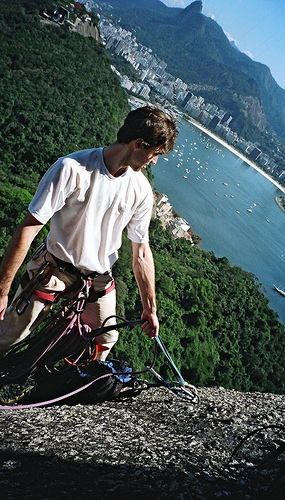

In [7]:
#data = "./resized-data"
data_dir = pathlib.Path(train_path)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

normal = list(data_dir.glob('Human/*'))
PIL.Image.open(str(normal[10]))

In [8]:
#Preparing the training and testing data
batch_size = 8
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names1 = train_ds.class_names
class_names2 = val_ds.class_names
print(class_names1)
print(class_names2)


Found 352 files belonging to 2 classes.
Using 282 files for training.
Found 352 files belonging to 2 classes.
Using 70 files for validation.
['Human', 'Non-human']
['Human', 'Non-human']


In [9]:
# we changed here

y_train = np.array([])
y_test = np.array([])
for x, y in train_ds:
  y_train = y.numpy()
  x_train = x.numpy()
for x, y in val_ds:
  y_test = y.numpy()
  x_test = x.numpy()

print(y_train)
print(y_test)

[[0. 1.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [10]:
#Checking the training and testing dataset shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8, 2)
(8, 224, 224, 3)
(8, 2)


In [11]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

from time import time

In [12]:
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score,auc,f1_score
from sklearn import metrics

In [13]:
import keras

from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# **CNN**

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
num_classes = 2

CNN_model = Sequential()
CNN_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(224,224,3),padding='same'))
CNN_model.add(LeakyReLU(alpha=0.1))
CNN_model.add(MaxPooling2D((2, 2),padding='same'))
CNN_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
CNN_model.add(LeakyReLU(alpha=0.1))
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
CNN_model.add(LeakyReLU(alpha=0.1))
CNN_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='linear'))
CNN_model.add(LeakyReLU(alpha=0.1))
CNN_model.add(Dense(num_classes, activation='sigmoid'))

In [15]:
CNN_model.compile( loss=tf.keras.losses.binary_crossentropy ,optimizer=tf.keras.optimizers.Adam( learning_rate=0.0001 ) ,metrics=['accuracy',
                                                                                                                    tf.keras.metrics.Precision(),
                                                                                                                    tf.keras.metrics.Recall(),
                                                                                                                    tf.keras.metrics.SpecificityAtSensitivity(0.5),
                                                                                                                    tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [16]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                   

In [17]:
batch_size = 8
epochs = 5
CNN_model.fit( train_ds, validation_data=val_ds, epochs=epochs , batch_size=batch_size )

Epoch 1/5
36/36 [==============================] - 17s 90ms/step - loss: 27.7223 - accuracy: 0.5780 - precision: 0.5559 - recall: 0.5638 - specificity_at_sensitivity: 0.6383 - sensitivity_at_specificity: 0.6099 - val_loss: 1.4079 - val_accuracy: 0.7143 - val_precision: 0.5641 - val_recall: 0.9429 - val_specificity_at_sensitivity: 0.7857 - val_sensitivity_at_specificity: 0.8571
Epoch 2/5
36/36 [==============================] - 3s 55ms/step - loss: 0.6911 - accuracy: 0.7908 - precision: 0.7500 - recall: 0.7660 - specificity_at_sensitivity: 0.8865 - sensitivity_at_specificity: 0.8794 - val_loss: 0.6004 - val_accuracy: 0.7286 - val_precision: 0.7297 - val_recall: 0.7714 - val_specificity_at_sensitivity: 0.8714 - val_sensitivity_at_specificity: 0.9000
Epoch 3/5
36/36 [==============================] - 3s 57ms/step - loss: 0.2674 - accuracy: 0.9149 - precision: 0.9039 - recall: 0.9007 - specificity_at_sensitivity: 0.9929 - sensitivity_at_specificity: 0.9787 - val_loss: 0.8597 - val_accuracy

In [18]:
CNN_result = CNN_model.evaluate( train_ds, batch_size=8)
print( 'Loss = {} %'.format( CNN_result[0]))
print( 'Accuracy = {} %'.format( CNN_result[1] * 100))
print( 'Precision = {} %'.format( CNN_result[2] * 100))
print( 'Recall = {} %'.format( CNN_result[3] * 100))
print( 'Specificity = {} %'.format( CNN_result[4] * 100))
print( 'Sensitivity = {} %'.format( CNN_result[5] * 100))

36/36 [==============================] - 2s 33ms/step - loss: 0.0928 - accuracy: 0.9787 - precision: 0.9720 - recall: 0.9858 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Loss = 0.09283848851919174 %
Accuracy = 97.8723406791687 %
Precision = 97.20279574394226 %
Recall = 98.58155846595764 %
Specificity = 100.0 %
Sensitivity = 100.0 %


In [19]:
CNN_result = CNN_model.evaluate( val_ds, batch_size=8)
print( 'Loss = {} %'.format( CNN_result[0]))
print( 'Accuracy = {} %'.format( CNN_result[1] * 100))
print( 'Precision = {} %'.format( CNN_result[2] * 100))
print( 'Recall = {} %'.format( CNN_result[3] * 100))
print( 'Specificity = {} %'.format( CNN_result[4] * 100))
print( 'Sensitivity = {} %'.format( CNN_result[5] * 100))

9/9 [==============================] - 1s 16ms/step - loss: 0.7072 - accuracy: 0.6857 - precision: 0.7123 - recall: 0.7429 - specificity_at_sensitivity: 0.8857 - sensitivity_at_specificity: 0.8714
Loss = 0.7071601152420044 %
Accuracy = 68.57143044471741 %
Precision = 71.23287916183472 %
Recall = 74.28571581840515 %
Specificity = 88.57142925262451 %
Sensitivity = 87.14285492897034 %


In [20]:
testy4=[]
probs4=[]

from tqdm import tqdm

for image_batch, labels_batch in tqdm(train_ds):
  val_prob=CNN_model.predict(image_batch)
  val_prob4 = val_prob[:,0]
  y_test4 = labels_batch[:,0]
  testy4.extend(y_test4)
  probs4.extend(val_prob4)


  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 1/36 [00:01<00:42,  1.21s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 2/36 [00:01<00:19,  1.75it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 3/36 [00:01<00:12,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 5/36 [00:01<00:06,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 6/36 [00:01<00:05,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 8/36 [00:01<00:03,  7.20it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 10/36 [00:02<00:03,  8.30it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 12/36 [00:02<00:02,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 14/36 [00:02<00:02,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 16/36 [00:02<00:02,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 17/36 [00:02<00:02,  8.69it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 18/36 [00:02<00:02,  8.53it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 19/36 [00:03<00:02,  8.41it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 20/36 [00:03<00:01,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 21/36 [00:03<00:01,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 22/36 [00:03<00:01,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 23/36 [00:03<00:01,  6.63it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 24/36 [00:03<00:02,  5.64it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 25/36 [00:04<00:01,  6.26it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 27/36 [00:04<00:01,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 29/36 [00:04<00:00,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 30/36 [00:04<00:00,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 31/36 [00:04<00:00,  8.85it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 32/36 [00:04<00:00,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 33/36 [00:04<00:00,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 35/36 [00:05<00:00,  9.91it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 36/36 [00:05<00:00,  6.94it/s]


<ipython-input-21-45f8815469f6>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


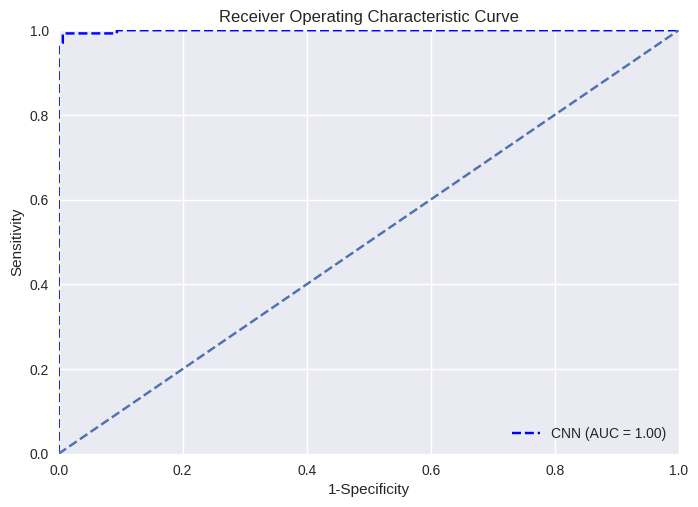

AUC of ROC = 0.9991169198163193
AUC = 0.9991169198163193


In [21]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

neg_probs = [0 for _ in range(len(probs4))]
fpr4, tpr4, thresholds4 = roc_curve(testy4, probs4)

fpr_4, tpr_4, thresholds_4 = roc_curve(testy4, neg_probs)

def plot_roc_curve(fpr4,tpr4):
  aucROC4 = metrics.roc_auc_score(testy4, probs4)
  AUC4 = metrics.auc(fpr4, tpr4)
  plt.plot(fpr4,tpr4,linestyle='--',color='blue',label="CNN (AUC = %0.2f)"% aucROC4)
  plt.plot(fpr_4,tpr_4, linestyle='--')

  plt.axis([0,1,0,1])
  plt.xlabel('1-Specificity')              # False Positive Rate= 1-Specificity
  plt.ylabel('Sensitivity')
  plt.legend(loc="lower right")
  plt.title("Receiver Operating Characteristic Curve")
  plt.show()
  print("AUC of ROC = " + str(aucROC4))
  print("AUC = " + str(AUC4))
  return aucROC4,AUC4

aucROC4,AUC4 = plot_roc_curve (fpr4,tpr4)


In [22]:
testy44=[]
probs44=[]

from tqdm import tqdm

for image_batch, labels_batch in tqdm(val_ds):
  val_prob=CNN_model.predict(image_batch)
  val_prob44 = val_prob[:,0]
  y_test44 = labels_batch[:,0]
  testy44.extend(y_test44)
  probs44.extend(val_prob44)


  0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 1/9 [00:00<00:06,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3/9 [00:00<00:01,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5/9 [00:01<00:00,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 7/9 [00:01<00:00,  8.31it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 9/9 [00:02<00:00,  3.53it/s]


<ipython-input-23-6b69d7086553>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


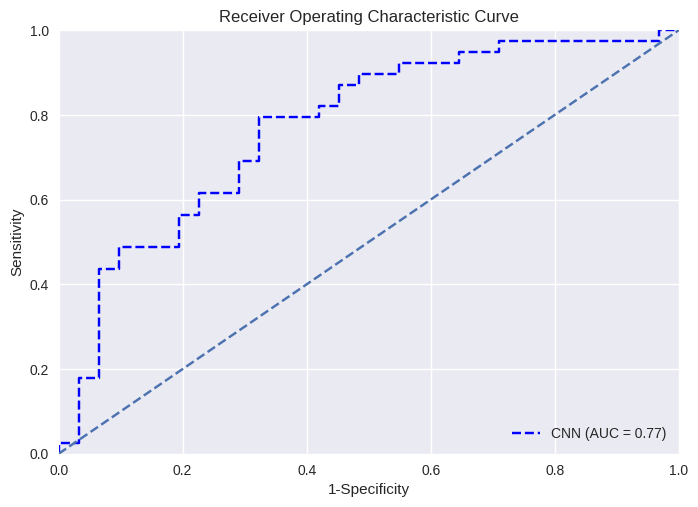

AUC of ROC = 0.7717121588089331
AUC = 0.7717121588089331


In [23]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

neg_probs = [0 for _ in range(len(probs44))]
fpr44, tpr44, thresholds44 = roc_curve(testy44, probs44)

fpr_44, tpr_44, thresholds_44 = roc_curve(testy44, neg_probs)

def plot_roc_curve(fpr44,tpr44):
  aucROC44 = metrics.roc_auc_score(testy44, probs44)
  AUC44 = metrics.auc(fpr44, tpr44)
  plt.plot(fpr44,tpr44,linestyle='--',color='blue',label="CNN (AUC = %0.2f)"% aucROC44)
  plt.plot(fpr_44,tpr_44, linestyle='--')

  plt.axis([0,1,0,1])
  plt.xlabel('1-Specificity')              # False Positive Rate= 1-Specificity
  plt.ylabel('Sensitivity')
  plt.legend(loc="lower right")
  plt.title("Receiver Operating Characteristic Curve")
  plt.show()
  print("AUC of ROC = " + str(aucROC44))
  print("AUC = " + str(AUC44))
  return aucROC44,AUC44

aucROC44,AUC44 = plot_roc_curve (fpr44,tpr44)


In [24]:
pip install opencv-python

In [25]:
import cv2
webcam = cv2.VideoCapture(1)

In [26]:
webcam

< cv2.VideoCapture 0x7e296593e810>

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


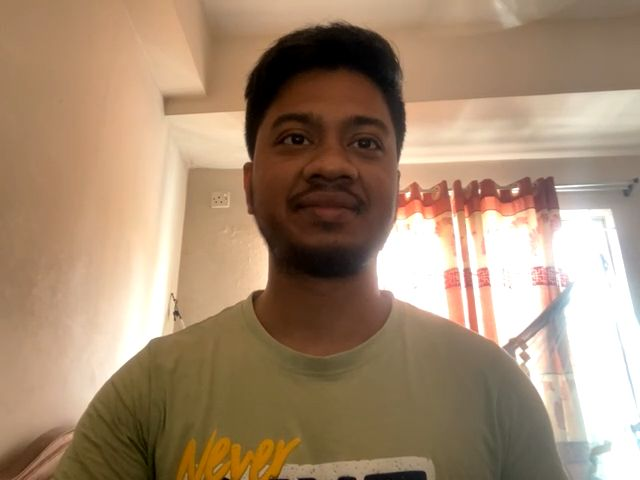

In [45]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [46]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import random

In [47]:
# Load a random image (you will need to adapt this to your dataset and file structure)
image_path = '/content/photo.jpg'

In [48]:
# Define a list of class labels (if applicable)
class_labels = [ 'Human', 'Non-human']

In [49]:
# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust the target size to match your model's input shape
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255.0  # Normalize the image data if necessary

In [50]:
# Make a prediction
predictions = CNN_model.predict(img)

1/1 [==============================] - 0s 27ms/step


In [51]:
# Get the predicted class label
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_label = class_labels[predicted_class_index[0]] if class_labels else str(predicted_class_index[0])

In [52]:
# Print the prediction result
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence: {predictions[0][predicted_class_index[0]]:.2f}')

Predicted class: Human
Confidence: 0.50
